In [1]:
import sys
sys.path.append("..")

## Libraries

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

## Load the data

In [3]:
from utils.helper import *

In [4]:
df = pd.read_csv("../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

In [5]:
target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

In [6]:
df = scaled_data(df)

In [7]:
seq_len = 15
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

## Dataloaders

In [8]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

# LSTM

In [9]:
# torch.Size([256, 5, 14]) -> [B, T, F]
# torch.Size([256])        -> [B]

In [10]:
class BaselineLSTM(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, dropout=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden1, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(input_size=hidden1, hidden_size=hidden2, batch_first=True)
        self.fc = nn.Linear(hidden2, 1)

    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.lstm1(x)
        out = self.drop1(out)
        out, _ = self.lstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)    # (B,)

In [11]:
lstm = BaselineLSTM(input_dim=len(features))

In [12]:
# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [ ]:
# Training the model using the train_loader, val_loader, and test_loader
lstm = lstm.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

num_epochs = 300
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in lstm.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    lstm.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = lstm(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    lstm.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = lstm(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(lstm.state_dict(), '../models/lstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 33057
Epoch 1/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 75.74it/s]


Epoch [1/300] - Train Loss: 1.131126, Val Loss: 17.624730
Epoch 2/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.61it/s]


Epoch [2/300] - Train Loss: 0.924821, Val Loss: 15.876401
Epoch 3/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 255.36it/s]


Epoch [3/300] - Train Loss: 0.747157, Val Loss: 13.962327
Epoch 4/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 271.15it/s]


Epoch [4/300] - Train Loss: 0.615023, Val Loss: 11.664913
Epoch 5/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 173.71it/s]


Epoch [5/300] - Train Loss: 0.503044, Val Loss: 9.379711
Epoch 6/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 259.04it/s]


Epoch [6/300] - Train Loss: 0.403888, Val Loss: 7.584505
Epoch 7/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 286.74it/s]


Epoch [7/300] - Train Loss: 0.318152, Val Loss: 6.171800
Epoch 8/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 283.17it/s]


Epoch [8/300] - Train Loss: 0.254834, Val Loss: 4.923615
Epoch 9/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 291.20it/s]


Epoch [9/300] - Train Loss: 0.205851, Val Loss: 3.989152
Epoch 10/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.50it/s]


Epoch [10/300] - Train Loss: 0.166379, Val Loss: 3.312288
Epoch 11/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 259.20it/s]


Epoch [11/300] - Train Loss: 0.137834, Val Loss: 2.696918
Epoch 12/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 270.45it/s]


Epoch [12/300] - Train Loss: 0.116695, Val Loss: 2.333486
Epoch 13/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 286.29it/s]


Epoch [13/300] - Train Loss: 0.101942, Val Loss: 1.981621
Epoch 14/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 290.44it/s]


Epoch [14/300] - Train Loss: 0.090004, Val Loss: 1.782356
Epoch 15/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.64it/s]


Epoch [15/300] - Train Loss: 0.079092, Val Loss: 1.492053
Epoch 16/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.19it/s]


Epoch [16/300] - Train Loss: 0.105004, Val Loss: 1.527396
Epoch 17/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 249.66it/s]


Epoch [17/300] - Train Loss: 0.097698, Val Loss: 1.178946
Epoch 18/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 294.64it/s]


Epoch [18/300] - Train Loss: 0.080060, Val Loss: 2.388255
Epoch 19/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 261.67it/s]


Epoch [19/300] - Train Loss: 0.058873, Val Loss: 1.091551
Epoch 20/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 289.55it/s]


Epoch [20/300] - Train Loss: 0.054305, Val Loss: 0.890086
Epoch 21/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 326.42it/s]


Epoch [21/300] - Train Loss: 0.048396, Val Loss: 0.922263
Epoch 22/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.64it/s]


Epoch [22/300] - Train Loss: 0.041331, Val Loss: 0.778349
Epoch 23/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 292.87it/s]


Epoch [23/300] - Train Loss: 0.036132, Val Loss: 0.720143
Epoch 24/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 271.11it/s]


Epoch [24/300] - Train Loss: 0.032797, Val Loss: 0.622089
Epoch 25/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 281.21it/s]


Epoch [25/300] - Train Loss: 0.029161, Val Loss: 0.587768
Epoch 26/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.17it/s]


Epoch [26/300] - Train Loss: 0.026955, Val Loss: 0.531324
Epoch 27/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 257.30it/s]


Epoch [27/300] - Train Loss: 0.024774, Val Loss: 0.518136
Epoch 28/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.99it/s]


Epoch [28/300] - Train Loss: 0.023145, Val Loss: 0.489708
Epoch 29/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 267.19it/s]


Epoch [29/300] - Train Loss: 0.022933, Val Loss: 0.499093
Epoch 30/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.91it/s]


Epoch [30/300] - Train Loss: 0.027082, Val Loss: 0.463008
Epoch 31/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 270.23it/s]


Epoch [31/300] - Train Loss: 0.034644, Val Loss: 0.591406
Epoch 32/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 332.79it/s]


Epoch [32/300] - Train Loss: 0.050684, Val Loss: 0.482521
Epoch 33/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 287.73it/s]


Epoch [33/300] - Train Loss: 0.023930, Val Loss: 0.733643
Epoch 34/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 255.66it/s]


Epoch [34/300] - Train Loss: 0.016636, Val Loss: 0.492116
Epoch 35/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 244.32it/s]


Epoch [35/300] - Train Loss: 0.016234, Val Loss: 0.456377
Epoch 36/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.93it/s]


Epoch [36/300] - Train Loss: 0.014883, Val Loss: 0.453821
Epoch 37/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.87it/s]


Epoch [37/300] - Train Loss: 0.014117, Val Loss: 0.447147
Epoch 38/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 213.97it/s]


Epoch [38/300] - Train Loss: 0.013229, Val Loss: 0.439404
Epoch 39/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 257.93it/s]


Epoch [39/300] - Train Loss: 0.012342, Val Loss: 0.436190
Epoch 40/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 271.44it/s]


Epoch [40/300] - Train Loss: 0.012138, Val Loss: 0.430223
Epoch 41/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 281.05it/s]


Epoch [41/300] - Train Loss: 0.011579, Val Loss: 0.430401
Epoch 42/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 282.68it/s]


Epoch [42/300] - Train Loss: 0.011241, Val Loss: 0.425194
Epoch 43/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 281.53it/s]


Epoch [43/300] - Train Loss: 0.010851, Val Loss: 0.423905
Epoch 44/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 288.27it/s]


Epoch [44/300] - Train Loss: 0.010613, Val Loss: 0.414288
Epoch 45/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 303.81it/s]


Epoch [45/300] - Train Loss: 0.010467, Val Loss: 0.411702
Epoch 46/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 287.85it/s]


Epoch [46/300] - Train Loss: 0.011048, Val Loss: 0.413573
Epoch 47/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 295.56it/s]


Epoch [47/300] - Train Loss: 0.012307, Val Loss: 0.406551
Epoch 48/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 290.56it/s]


Epoch [48/300] - Train Loss: 0.015503, Val Loss: 0.427728
Epoch 49/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 270.23it/s]


Epoch [49/300] - Train Loss: 0.016580, Val Loss: 0.542215
Epoch 50/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 235.76it/s]


Epoch [50/300] - Train Loss: 0.012999, Val Loss: 0.422073
Epoch 51/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 253.23it/s]


Epoch [51/300] - Train Loss: 0.012978, Val Loss: 0.435035
Epoch 52/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 253.78it/s]


Epoch [52/300] - Train Loss: 0.013121, Val Loss: 0.439210
Epoch 53/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 314.17it/s]


Epoch [53/300] - Train Loss: 0.010542, Val Loss: 0.515427
Epoch 54/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 257.49it/s]


Epoch [54/300] - Train Loss: 0.009170, Val Loss: 0.399148
Epoch 55/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 256.08it/s]


Epoch [55/300] - Train Loss: 0.008619, Val Loss: 0.415279
Epoch 56/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 300.88it/s]


Epoch [56/300] - Train Loss: 0.008171, Val Loss: 0.403167
Epoch 57/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 289.10it/s]


Epoch [57/300] - Train Loss: 0.007068, Val Loss: 0.424642
Epoch 58/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 318.73it/s]


Epoch [58/300] - Train Loss: 0.006988, Val Loss: 0.404876
Epoch 59/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 284.69it/s]


Epoch [59/300] - Train Loss: 0.006434, Val Loss: 0.416651
Epoch 60/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 281.96it/s]


Epoch [60/300] - Train Loss: 0.006786, Val Loss: 0.412360
Epoch 61/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 314.06it/s]


Epoch [61/300] - Train Loss: 0.006362, Val Loss: 0.448938
Epoch 62/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.85it/s]


Epoch [62/300] - Train Loss: 0.006622, Val Loss: 0.421152
Epoch 63/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.09it/s]


Epoch [63/300] - Train Loss: 0.006225, Val Loss: 0.440311
Epoch 64/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.47it/s]

Epoch [64/300] - Train Loss: 0.006359, Val Loss: 0.420975
Early stopping triggered after epoch 64

Best validation loss: 0.399148


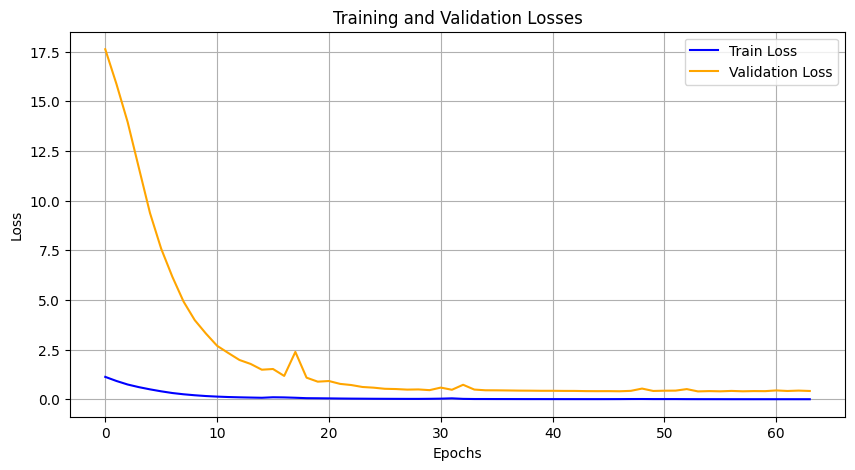

In [14]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [15]:
# Load best model for testing
lstm.load_state_dict(torch.load('../models/lstm15.pth'))

<All keys matched successfully>

In [16]:
# Test phase
lstm.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = lstm(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.316204


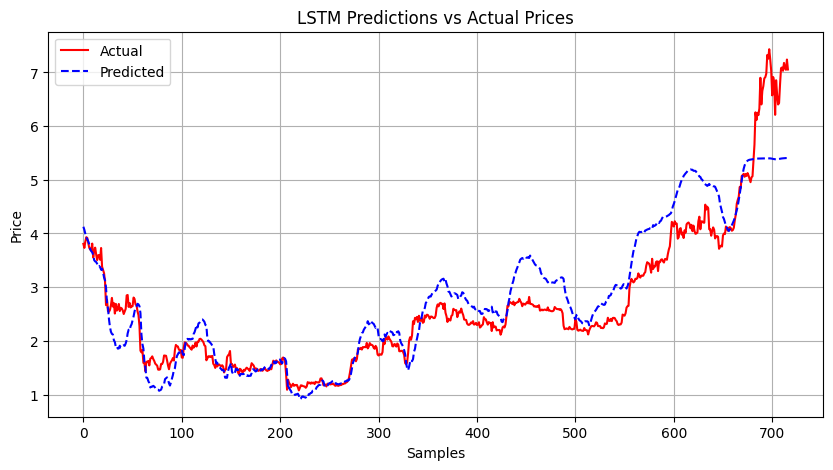

In [18]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()